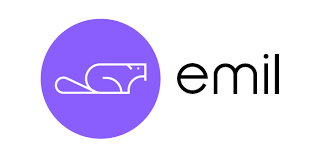

In [14]:
import ipywidgets as widgets
from IPython.display import display

In [15]:
import pandas as pd
import plotly.express as px
from ipywidgets import interact, interactive, fixed, interactive_output
import io

In [16]:
df = pd.read_csv("Tiller_order_data.csv")

# Transforme les dates en format datetime
df["date_opened"] = pd.to_datetime(df["date_opened"])
df["date_closed"] = pd.to_datetime(df["date_closed"])

# Mettre en index la date d'ouverture de commande
df = df.set_index(df["date_opened"])

C:\Users\user\AppData\Local\Temp\ipykernel_10736\824775238.py:1: DtypeWarning:

Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.



In [17]:
id_store_dropdown = widgets.Dropdown(
    value=8052,
    options=df.id_store.unique()
)

In [18]:
date_debut_picker = widgets.DatePicker(
    options=df.date_opened.unique(),
    value=df.date_opened[0]
)

In [19]:
date_fin_picker = widgets.DatePicker(
    options=df.date_closed.unique(),
    value=df.date_closed[0]
)

In [20]:
import plotly.graph_objects as go

def revenue_over_time(df_store):
    df_revenue = df_store[df_store.dim_status=="CLOSED"].resample("D").m_cached_payed.sum()

    fig = px.line(df_revenue,
                  y="m_cached_payed",
                  title="Chiffre d'affaire au cours du temps")
    fig.update_xaxes(
        rangeselector=dict(
            buttons=list([
                dict(count=7, label="Last 7days", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        )
    )
    fig.show()

def clients_over_time(df_store):
    df_revenue = df_store[df_store.dim_status=="CLOSED"].resample("D").m_cached_payed.sum()
    df_nb_customer = df_store[df_store.dim_status=="CLOSED"].resample("D")["m_nb_customer"].sum()

    df_average_basket = df_revenue / df_nb_customer

    fig_panier_moyen = go.Scatter(x=df_average_basket.index,
                                  y=df_average_basket,
                                  name="panier moyen", 
                                  mode="lines", 
                                  line_color="#000000")

    fig = px.bar(df_nb_customer,
                 title="Nombre de clients au cours du temps")
    fig.add_trace(fig_panier_moyen)
    fig.update_xaxes(tickformat="%d/%m/%Y")
    fig.update_xaxes(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        )
    )
    fig.show()

def best_staff(df_store):
    df_store.loc[df_store["id_waiter"].isnull(), "id_waiter"] = "unknown"

    df_waiter = df_store.groupby("id_waiter", as_index=False)["m_cached_payed"].sum()

    fig = px.pie(
        df_waiter,
        names='id_waiter',
        values='m_cached_payed',
        color='id_waiter',
        title = 'Répartition des commandes non enregistrées par un serveur'
    )
    fig.update_traces(
        textinfo='percent+label'
    )
    fig.show()

In [21]:
def display_dash(df, id_store_dropdown, date_debut_picker, date_fin_picker):
    df_filtered = df[df.id_store == id_store_dropdown]
    df_filtered = df_filtered[df_filtered.date_opened > str(date_debut_picker)]
    df_filtered = df_filtered[df_filtered.date_opened < str(date_fin_picker)]
    revenue_over_time(df_filtered)
    clients_over_time(df_filtered)
    best_staff(df_filtered)

In [22]:
from ipywidgets import HBox, VBox

In [23]:
ui = VBox([id_store_dropdown, HBox([date_debut_picker, date_fin_picker])])

In [24]:
out = interactive_output(
    display_dash, 
    {
        'df': fixed(df),
        'id_store_dropdown': id_store_dropdown,
        'date_debut_picker': date_debut_picker,
        'date_fin_picker': date_fin_picker
    }
)
display(ui, out)

Output()

c) Depuis un terminal, lancez la commande :
```
voila --TagRemovePreprocessor.remove_cell_tags hide ce_notebook.ipynb
```

# 5) Déploiement de la webapp avec ngrok

On souhaite maintenant pouvoir partager notre webapp sans pour autant la déployer sur serveur sur un autre ordinateur. 

Pour cela, nous allons utiliser la librairie ngrok dont la documentation peut être consultée à [cette adresse](https://voila.readthedocs.io/en/stable/deploy.html). Mais nous allons vous guider dans la suite de cette partie.

a) Installer [ngrok](https://ngrok.com/download)

https://ngrok.com/download

b) Unzippez l'archive, puis authentifiez vous avec votre token :

```./ngrok authtoken <token>```

c) Assurez-vous qu'une webapp voilà est déjà lancée en local (cf : commande voila ci-dessus)

d) Lancer un tunnel sur le port 8866 :

```./ngrok http 8866```

e) Cliquez sur le lien affiché dans le terminal (```Forwarding```).
Vous pouvez envoyer cette url à votre voisin, il pourra acceder à votre webapp !

# [Bonus] Déploiement d'une webapp avec Binder

Pour pouvoir utiliser [Binder](https://jupyter.org/binder), il faut au préalable avoir pushé son notebook dans un repo git et avoir rajouté un fichier 'requirements.txt' contenant les librairies nécessaires pour faire tourner votre projet.

Ensuite, il suffit d'aller sur https://mybinder.org/ et :
- dans 'GitHub', copier coller l'URL de votre projet git
- dans 'Path to a notebook file (optional)', écrivez 'voila/render/ce_notebook.ipynb' en précisant bien 'URL' au lieu de 'File'. Celà permet de spécifier à Binder qu'il faut directement utiliser Voila pour créer la webapp.

Cliquez ensuite sur 'lauch'. Une image docker de votre projet sera créer grace au fichier 'requirements.txt'. Vous aurez ensuite un lien pour lancer un conteneur docker autonome qui vous permettra d'acceder à votre application web. Pour chaque utilisateur utilisant ce lien, un conteneur docker sera créé.